In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

In [2]:
mushroom_data = pd.read_csv('mushroom.csv')

In [3]:
def update_cov(X,mean,weights,group):
    """a function to estimate the covariance with a new mean
    Parameter
    -------------------------------
    X : array-like
    the data with which we want to estimate the new covariance

    mean : array-like
    the new mean that doesn't correspond to the 'true mean'

    weights : arrar-like 
    the matrix of weights of the whole data

    group : int
    the group in which we want to update
    --------------------------------
    """
    sum_of_mat = np.zeros((X.shape[1],X.shape[1]))
    for i in range(X.shape[0]):
        temporal_cov = weights[i,group]*np.matmul((X[i,:]-mean).reshape((X.shape[1],1)),
                                                      (X[i,:]-mean).reshape((1,X.shape[1])))
        sum_of_mat += temporal_cov
    sum_of_weights = np.sum(weights[:,group])
    weighted_sigma = sum_of_mat/sum_of_weights
    return weighted_sigma

In [4]:
mushroom_data

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1
54031,82,2,3,2,1.186164,490,12,0.943195,1
54032,82,5,3,2,0.915593,584,12,0.888450,1
54033,79,2,3,2,1.034963,491,12,0.888450,1


In [5]:
n_samples = mushroom_data.shape[0]

In [6]:
mushroom_data['label'] = np.zeros((n_samples))
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if mushroom_data.loc[i,'class'] == 1 and random == 0:
        mushroom_data.loc[i,'label'] = 1
    else:
        mushroom_data.loc[i,'label'] = 99

In [7]:
mushroom_data

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class,label
0,1372,2,2,10,3.807467,1545,11,1.804273,1,99.0
1,1461,2,2,10,3.807467,1557,11,1.804273,1,99.0
2,1371,2,2,10,3.612496,1566,11,1.804273,1,1.0
3,1261,6,2,10,3.787572,1566,11,1.804273,1,99.0
4,1305,6,2,10,3.711971,1464,11,0.943195,1,99.0
...,...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1,1.0
54031,82,2,3,2,1.186164,490,12,0.943195,1,99.0
54032,82,5,3,2,0.915593,584,12,0.888450,1,99.0
54033,79,2,3,2,1.034963,491,12,0.888450,1,99.0


In [8]:
list_of_inertia = []
for i in range(1,7):
    list_of_inertia.append(KMeans(n_clusters=i).fit(X=mushroom_data.drop(['class','label'], axis=1).to_numpy()).inertia_)

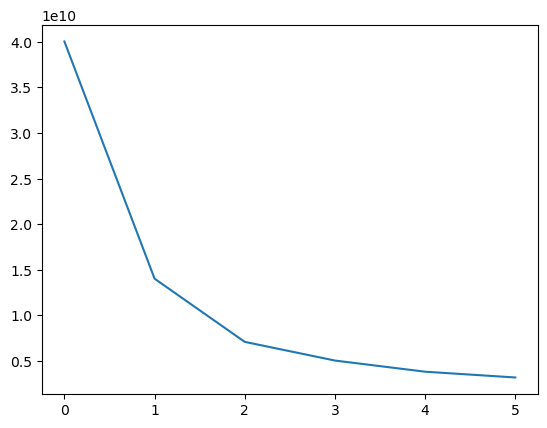

In [9]:
plt.plot(list_of_inertia)

In [10]:
mushroom_data['cluster_lab'] = KMeans(n_clusters=3).fit(X=mushroom_data.drop(['class','label'], axis=1).to_numpy()).labels_

In [11]:
fit_cluster = KMeans(n_clusters=3).fit(X=mushroom_data.drop(['class','label'], axis=1).to_numpy())

In [12]:
mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label']

cluster_lab
0    4159
1     774
2    2334
Name: label, dtype: int64

In [13]:
positive_cluster = np.where(np.array(mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label']) == 
                            np.max(np.array(mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label'])))[0][0]

In [14]:
distances = np.ones((3))
for i in range(3):
    distances[i] = np.linalg.norm(fit_cluster.cluster_centers_[1,:]-fit_cluster.cluster_centers_[i,:])
negative_cluster = np.where(distances == np.max(distances))[0][0]

In [15]:
positive_data = mushroom_data[mushroom_data['label'] == 1]
reliable_negative = mushroom_data[mushroom_data['cluster_lab'] == negative_cluster]

In [16]:
label_1 = positive_data.drop(['class','label','cluster_lab'], axis=1).to_numpy()
label_0 = reliable_negative.drop(['class','label','cluster_lab'], axis=1).to_numpy()

In [58]:
mean_1 = np.mean(label_1,axis=0)
mean_0 = np.mean(label_0, axis=0)

In [59]:
cov_1 = np.cov(label_1, rowvar=False)
cov_0 = np.cov(label_0, rowvar=False)

In [60]:
weights = np.zeros((n_samples,2))

In [61]:
weights

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [62]:
for i in range(n_samples):
    if mushroom_data.loc[i,'cluster_lab'] == negative_cluster:
        mushroom_data.loc[i,'label'] = 0

In [63]:
pi_0 = 1/2
pi_1 = 1/2

In [64]:
dict_pi = {'pi_0':pi_0,'pi_1':pi_1}

In [65]:
dict_mean = {'mean_0':mean_0,'mean_1':mean_1}
dict_cov = {'cov_0':cov_0,'cov_1':cov_1}

In [66]:
data_gmm = mushroom_data.to_numpy()[:,:8]
iterations = 100
count = 0

#to opti : put the weights to O/1 before so only one condition in the loop

while count<=iterations:
    count+=1
    for group in range(2):
        for i in range(n_samples):
            if mushroom_data.loc[i,'label'] == 99:
                x_test = data_gmm[i,:]
                numerator = dict_pi['pi_{0}'.format(group)]*multivariate_normal.pdf(x=x_test,
                                                                                    mean=dict_mean['mean_{0}'.format(group)],
                                                                                    cov=dict_cov['cov_{0}'.format(group)],allow_singular=True)
                denom = pi_0*multivariate_normal.pdf(x=x_test,mean=mean_0,cov=cov_0,allow_singular=True)+pi_1*multivariate_normal.pdf(x=x_test,mean=mean_1,cov=cov_1,allow_singular=True)
                result = numerator/denom
                weights[i,group] = result           
            elif mushroom_data.loc[i,'label'] == group:
                weights[i,group] = 1
            else:
                weights[i,group] = 0
        sum_of_weights = np.sum(weights[:,group])
        dict_pi['pi_{0}'.format(group)] = np.mean(weights[:,group])
        dict_mean['mean_{0}'.format(group)] = np.sum((data_gmm*(weights[:,group].reshape(n_samples,1))),axis=0)/sum_of_weights
        dict_cov['cov_{0}'.format(group)] = update_cov(X=data_gmm,group=group,
                                                       mean=dict_mean['mean_{0}'.format(group)],weights=weights)
        
                
                
        

/tmp/ipykernel_4464/1789460998.py:13: RuntimeWarning: overflow encountered in scalar multiply
  numerator = dict_pi['pi_{0}'.format(group)]*multivariate_normal.pdf(x=x_test,
/tmp/ipykernel_4464/1789460998.py:25: RuntimeWarning: invalid value encountered in divide
  dict_mean['mean_{0}'.format(group)] = np.sum((data_gmm*(weights[:,group].reshape(n_samples,1))),axis=0)/sum_of_weights


ValueError: array must not contain infs or NaNs

In [ ]:
mushroom_data.head()

In [ ]:
mushroom_data.to_numpy()[1,:8].shape

In [27]:
dict_cov['cov_1'].shape

(8, 8)

In [28]:
dict_cov['cov_0'].shape

(8, 8)

In [38]:
dict_mean['mean_0']

749.7653515618318

In [48]:
np.sum((data_gmm*(weights[:,0].reshape(n_samples,1))),axis=0).shape

(8,)